In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from sklearn import metrics


In [4]:
#CARGAMOS LOS DATOS
data = pd.read_csv('../data/processed/accidentes.csv')
data['FECHA'] = pd.to_datetime(data['FECHA'])
data.set_index('FECHA', inplace=True)
data = data.asfreq('D')
data = data.sort_index()
data

,Accidentes,Capped
FECHA,,
2014-07-04,23,47.5
2014-07-05,115,115.0
2014-07-06,74,74.0
2014-07-07,164,164.0
2014-07-08,116,116.0
...,...,...
2018-11-15,105,105.0
2018-11-16,133,133.0
2018-11-17,116,116.0


Datos de entrenamiento : 2014-07-04 00:00:00 --- 2018-08-31 00:00:00  (n=1520)
Datos de Prueba  : 2018-09-01 00:00:00 --- 2018-11-19 00:00:00  (n=80)


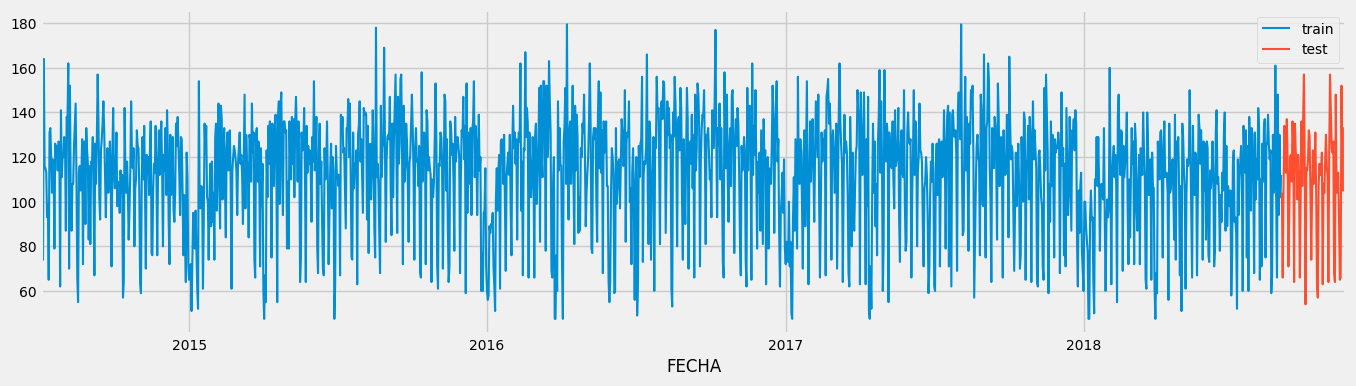

In [6]:
#SEPARAMOS Y VISUALIZAMOS LOS DATOS DE TRAIN Y TEST
steps = 80
data_train = data[:-steps]
data_test  = data[-steps:]

print(f"Datos de entrenamiento : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Datos de Prueba  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax = plt.subplots(figsize=(15, 4))
data_train['Capped'].plot(ax=ax, label='train')
data_test['Capped'].plot(ax=ax, label='test')
ax.legend()

In [ ]:
#BUSCAMOS LOS PARAMETROS MAS ADECUADOS PARA ENTRENAR EL MODELO
steps = 80
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 10
             )

#LAGS USADOS PARA ENCONTRAR EL ADECUADO PARA PREDECIR
lags_grid = [35, 50, 65]

# PARAMETROS DEL REGRESSOR
param_grid = {'n_estimators': [1000, 1500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data_train['Capped'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = False,
                        metric             = 'mean_absolute_error',
                        initial_train_size = int(len(data_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        n_jobs             = 'auto',
                        verbose            = False
               )

In [ ]:
results_grid

In [66]:
#COLOCAMOS LOS PARAMETROS ADECUADOS DEL MODELO
regressor = RandomForestRegressor(max_depth=10, n_estimators=1000, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 65
             )

forecaster.fit(y=data_train['Capped'])

In [67]:
forecaster.summary()

ForecasterAutoreg 
Regressor: RandomForestRegressor(max_depth=10, n_estimators=1000, random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65] 
Transformer for y: None 
Transformer for exog: None 
Window size: 65 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2014-07-04 00:00:00'), Timestamp('2018-08-31 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 1000, 'n_jobs'

In [68]:
#PREDECIMOS LOS VALORES DE TEST Y COMPARAMOS
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2018-09-01    114.007468
2018-09-02     71.019241
2018-09-03    116.552804
2018-09-04    103.156464
2018-09-05    119.381798
Freq: D, Name: pred, dtype: float64

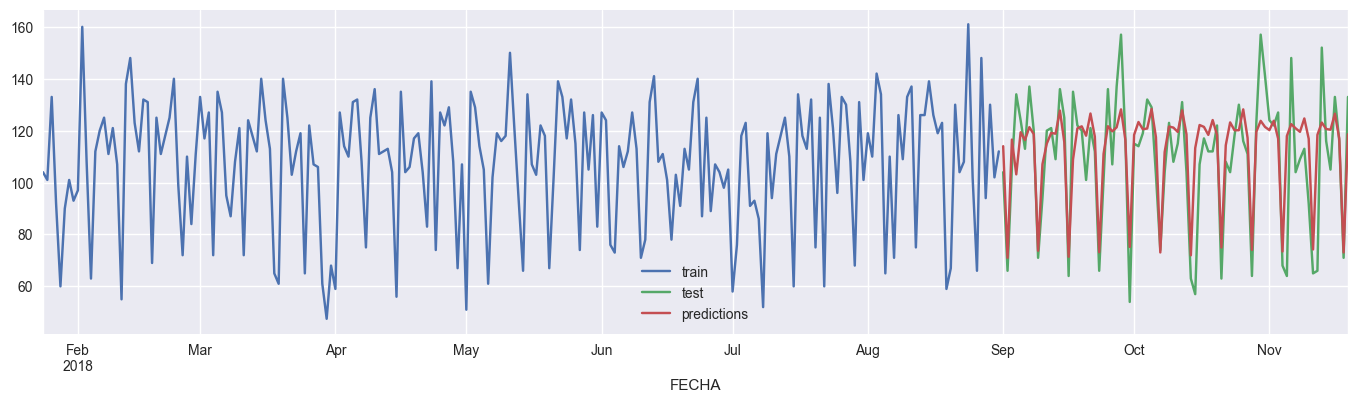

In [73]:
#COMPARAMOS LOS VALORES ORIGINALES(TEST) CON LA PREDICCION 
fig, ax = plt.subplots(figsize=(15, 4))
data_train['Capped'][1300:].plot(ax=ax, label='train')
data_test['Capped'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend()

C:\Users\Cristian\AppData\Local\Temp\ipykernel_41904\2693924093.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


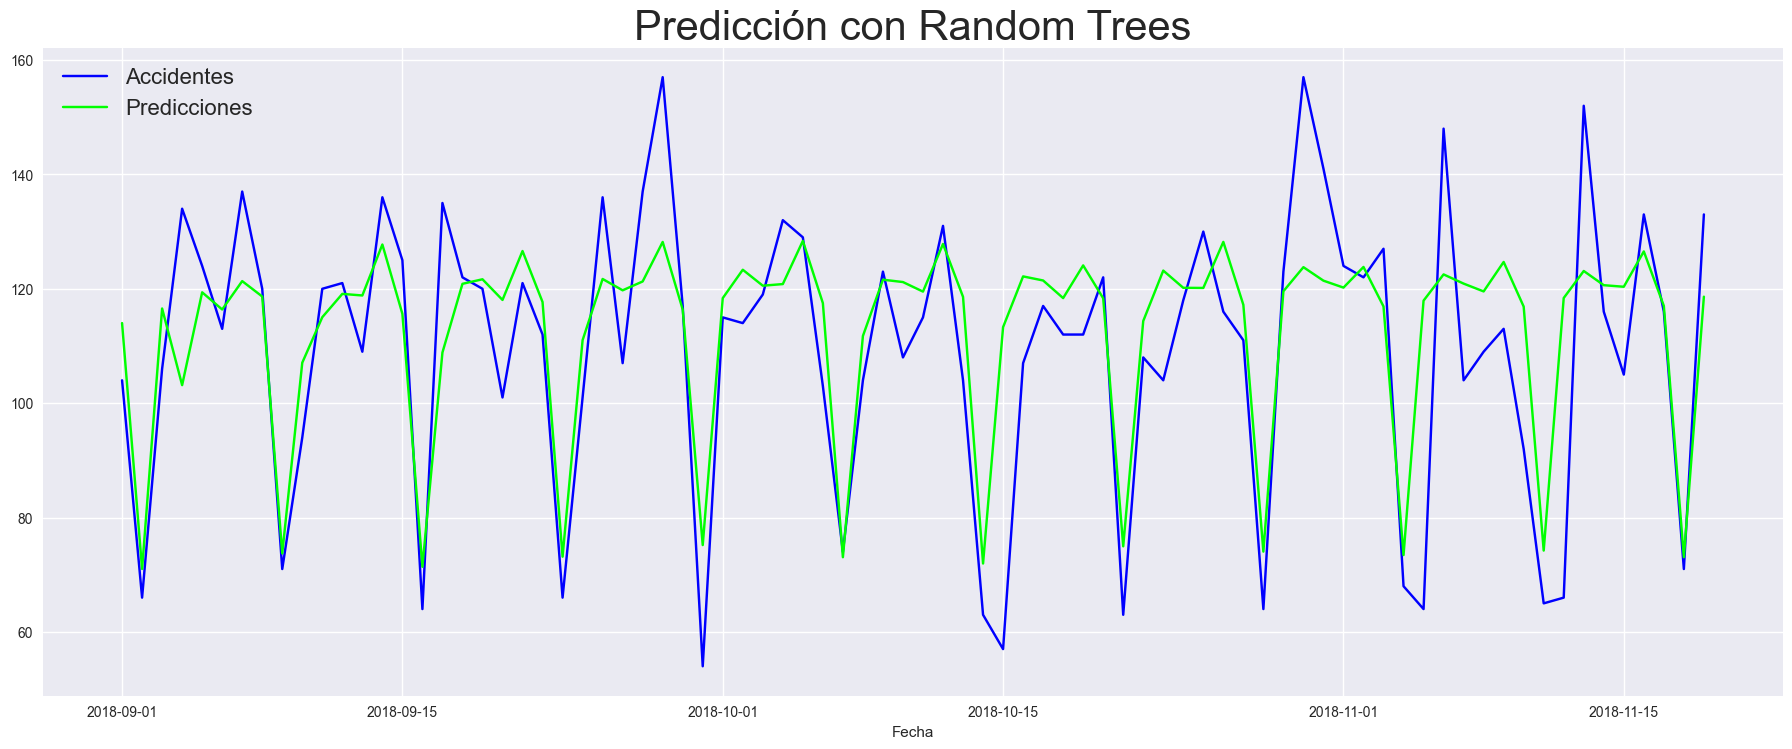

In [70]:
#VISUALIZAMOS LOS VALORES DE TEST CON LA PREDICCION
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (20, 8)

plt.plot(data_test['Capped'],color="blue" ,label="Accidentes")
plt.plot(predictions, color="lime", label="Predicciones")
plt.title("Predicción con Random Trees", fontsize=30);
plt.xlabel('Fecha')
plt.ylabel('')
plt.legend( fontsize=16)
plt.show()

In [74]:
#PREDICCION EN FECHAS NUEVAS
predictions2 = forecaster.predict(steps=steps+152)
predictions2.head(5)

2018-09-01    114.007468
2018-09-02     71.019241
2018-09-03    116.552804
2018-09-04    103.156464
2018-09-05    119.381798
Freq: D, Name: pred, dtype: float64

C:\Users\Cristian\AppData\Local\Temp\ipykernel_41904\1866491210.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


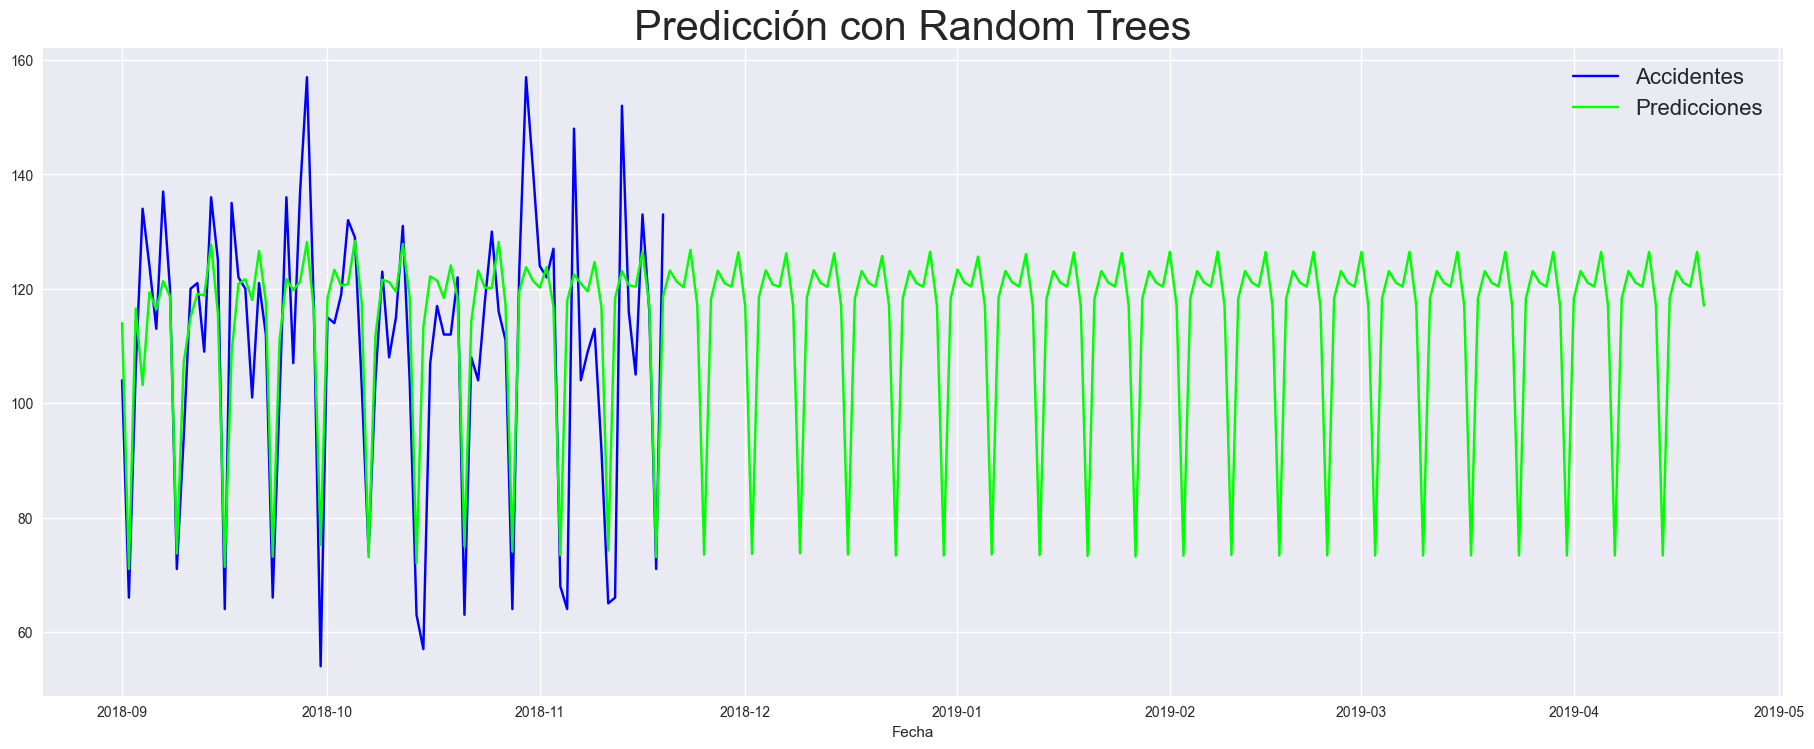

In [75]:
#VISUALIZAMOS LOS VALORES DE PREDCCION
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (20, 8)

plt.plot(data_test['Capped'],color="blue" ,label="Accidentes")
plt.plot(predictions2, color="lime", label="Predicciones")
plt.title("Predicción con Random Trees", fontsize=30);
plt.xlabel('Fecha')
plt.ylabel('')
plt.legend( fontsize=16)
plt.show()

In [71]:
# METRICAS DE EVALUACION
MSE = mean_squared_error(y_true = data_test['Capped'],y_pred = predictions)
MAE = metrics.mean_absolute_error(y_true = data_test['Capped'],y_pred = predictions)
MAPE = metrics.mean_absolute_percentage_error(y_true = data_test['Capped'],y_pred = predictions)
RMSE = np.sqrt(metrics.mean_squared_error(y_true = data_test['Capped'],y_pred = predictions))
R2 = metrics.r2_score(y_true = data_test['Capped'],y_pred = predictions)

print(f"Test error (MSE): {MSE}")
print(f"Test error (MAE): {MAE}")
print(f"Test error (MAPE): {MAPE}")
print(f"Test error (RMSE): {RMSE}")
print(f"Test error (R2): {R2}")

Test error (MSE): 264.48349953516237
Test error (MAE): 11.663018552495092
Test error (MAPE): 0.12184511016179396
Test error (RMSE): 16.262948672831822
Test error (R2): 0.5739938860923683
